In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import copy
import time
import tabulate
import numpy as np
sys.path.append(os.path.join(os.path.abspath(""), ".."))

In [3]:
from app.models import Classifier
from app.utils import ImageWrapper 
from app.transforms import FFT, IFFT, CreateOnesMask
from app.filters import CreateKernel, Convolve, Canny, HOG
from app.imager import ImageLoader, DefectViewer, Show, Exposure
from app.custom import RemoveBusBars, Orient, HighlightFrontGrid
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

In [4]:
# Seed used in show to show the same images when num_images option is set
seed = 1234
scores = []
legends = []

In [5]:
# Analyzing which defect 
defect_class = 'FrontGridInterruption'
n_samples = 800

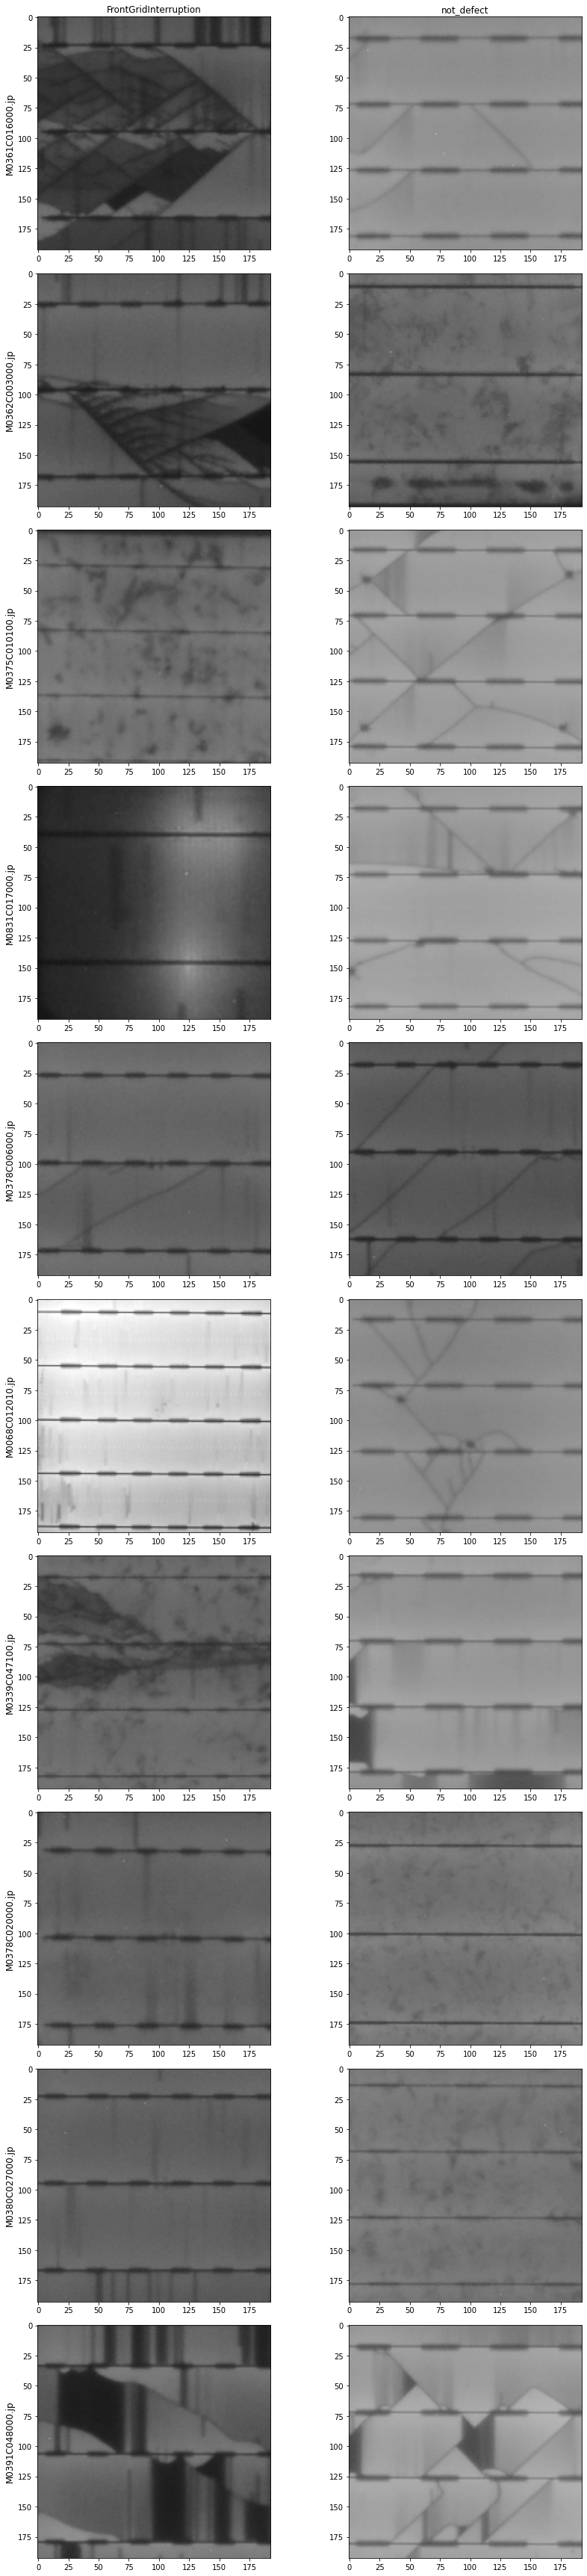

In [6]:
# Load 10 examples and name the category for it. Category is like a title for images
defect_class = defect_class
defect = (DefectViewer(row_chop=15, col_chop=15) << (ImageLoader(defect_class='FrontGridInterruption') << n_samples))
defect.category = 'FrontGridInterruption'

# Make the other teh same length as the defect
num_samples = len(defect)

# Get the not this defect
not_defect = (DefectViewer(row_chop=15, col_chop=15) << (ImageLoader(defect_class='FrontGridInterruption', is_not=True) << n_samples))
not_defect.category = 'not_defect'

# Create a copy of the defect
defect_ = defect.copy()

# Eliminate any not defect images that are in defect
defect = defect - not_defect

# ELiminate any defect images that are in not defect
not_defect = not_defect - defect_


# View both the defect and the clean class
# I am using a tuple in this case as defect and clean are ImageWrapper objects
# Show random 5 out of the 10 images. Using the seed will ensure the same 5 are shown everytime
_ = Show(num_images=10, seed=seed) << (defect, not_defect)

In [ ]:
print(len(defect))
print(len(not_defect))

In [ ]:
# 1. Base model on raw data
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': None}
cla = Classifier(defect, not_defect, LogisticRegression, None)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

scores.append(score)
legends.append('base linear model')

In [ ]:
# 2. Base model on raw data with pca
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(defect, not_defect, LogisticRegression, None)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

scores.append(score)
legends.append('Linear model with reduced(PCA) dimensions')

In [ ]:
# 3. Gradient Boosted Classifier 
params = {'seed': 14376,'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'pca_dims': 160}
cla = Classifier(defect, not_defect, GradientBoostingClassifier, None)
     
# When done, return the score 
score = cla.fit(**params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

scores.append(score)
legends.append('Non-linear model with reduced(PCA) dimensions')

## Fix orientation of images

In [ ]:
# Get the oriented images and HOG
start = time.perf_counter()
oriented_defect = Orient(num_jobs=20) << defect
oriented_not_defect = Orient(num_jobs=20) << not_defect
print(time.perf_counter() - start)

# View both the defect and the clean class
# I am using + operator as oriented_defect and oriented_clean are tuples
_ = Show(num_images=10, seed=seed) << oriented_defect + oriented_not_defect

In [ ]:
# 4. Linear classifier on oriented defects
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(oriented_defect[-1], oriented_not_defect[-1], LogisticRegression, None)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

scores.append(score)
legends.append('Linear model with reduced(PCA) dimensions and oriented images')

In [ ]:
# 5. Gradoent Boosted classifier on oriented defects
params = {'seed': 14376,'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'pca_dims': 160}
cla = Classifier(oriented_defect[-1], oriented_not_defect[-1], GradientBoostingClassifier, None)
     
# When done, return the score 
score = cla.fit(**params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

scores.append(score)
legends.append('Non-linear model with reduced(PCA) dimensions and oriented images')

## Remove the bus bars

In [ ]:
# Remove the BusBars
nobus_defect = RemoveBusBars() << oriented_defect
nobus_not_defect = RemoveBusBars() << oriented_not_defect

In [ ]:
params = {'seed': 14376,'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'pca_dims': 160}
cla = Classifier(nobus_defect[-1], nobus_not_defect[-1], GradientBoostingClassifier, None)
     
# When done, return the score 
score = cla.fit(**params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

scores.append(score)
legends.append('Non-linear model with reduced(PCA) dimensions, oriented images and no bus bars')

## CNN on the original images

In [ ]:
from app.models import ModelCNN

lr = 0.0001
optimizer_params = {'name': 'sgd', 'lr': lr, 'nesterov': True, 'momentum': 0.9}
scheduler_params = {'lr_min': lr, 't_mul': 2}
model_params = {'num_output_classes': 2, 'channels': ((1, 5), (20, 3), (20, 3))}

model = ModelCNN(oriented_defect[-1], oriented_not_defect[-1], model_params, optimizer_params, scheduler_params)

score = model.fit(num_epochs=500)

print(score)

scores.append(score)
legends.append('CNN on oriented images')

In [ ]:
import pickle
import random
with open(f'results_{random.randint(0, 2**32)}', 'wb') as outfi:
    pickle.dump((scores, legends), outfi)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(scores))
y = np.array(scores)
plt.xticks(x, legends, rotation=90)
plt.plot(x, y, '-')
plt.show()

In [ ]:
raise KeyError("Ended")

In [ ]:
# def_mins = oriented_defect[-1].images.min(axis=(-2, -1))
# cle_mins = oriented_clean[-1].images.min(axis=(-2, -1))
def_mins = defect.images.min(axis=(-2, -1))
cle_mins = clean.images.min(axis=(-2, -1))
plt.hist(def_mins, color='b')
plt.hist(cle_mins, color='r')

In [ ]:
# def_maxs = oriented_defect[-1].images.max(axis=(-2, -1))
# cle_maxs = oriented_clean[-1].images.max(axis=(-2, -1))
def_maxs = defect.images.max(axis=(-2, -1))
cle_maxs = clean.images.max(axis=(-2, -1))
plt.hist(def_maxs, color='b')
plt.hist(cle_maxs, color='r')

In [ ]:
import matplotlib.pyplot as plt
class Enhance:

    def __init__(self, consume_kwargs=False, num_jobs=1, **kwargs):
        """
       
        :param num_jobs: Number of jobs to parallelize HOG
        """
        self.num_jobs = num_jobs
        self.params = {}
      
    def __lshift__(self, in_imw):

        if isinstance(in_imw, tuple):
            in_imw = in_imw[-1]

        # Apply the transformation to these images
        out_img = self.apply(~in_imw)

        category = in_imw.category
        category += f'\n Enhance'
        out_imw = ImageWrapper(out_img, category=category, image_labels=copy.deepcopy(in_imw.image_labels))

        return in_imw, out_imw

    def apply(self, in_imgs, do_debug=False):
        """

        """
        
        # in_stretch = Exposure(mode='stretch').apply(in_imgs)
        # sobel_imgs = Exposure(mode='stretch').apply(in_imgs)
        hog_imgs = HOG(pixels_per_cell=(5, 5), num_jobs=20).apply(in_imgs)
        
        # kernel = CreateKernel(dim=2, kernel="sobel", axis=0).apply()
        # sobel_imgs = Convolve(num_jobs=self.num_jobs).apply(sobel_imgs, kernel)
        
        # sobel_imgs = Exposure(mode='stretch').apply(sobel_imgs)
        # sobel_imgs = Exposure(mode='stretch').apply(sobel_imgs)

#         # Form an adaptive contrast
#         # gamma_imgs = Exposure(mode='gamma', gamma=0.5, gain=2).apply(in_stretch)
#         gamma_imgs = Exposure(mode='adaptive').apply(in_stretch)
#         print(gamma_imgs.min(), gamma_imgs.max())
        
#         gamma_imgs = Exposure(mode='gamma', gamma=0.5, gain=0.1).apply(gamma_imgs)
        
#         stretched_imgs = Exposure('stretch').apply(gamma_imgs)
#         print(stretched_imgs.min(), stretched_imgs.max())
#         stretched_imgs[stretched_imgs < 0.001] = 0.001
        
#         kernel = CreateKernel(dim=2, kernel="sobel", axis=0).apply()
        
#         sobel_imgs = Convolve(num_jobs=self.num_jobs).apply(stretched_imgs, kernel)
        
        # plt.figure(figsize=(6.4, 4.8))
        # plt.scatter(in_imgs.flatten(), stretched_imgs.flatten(), color='green')
        # plt.scatter(in_stretch.flatten(), gamma_imgs.flatten(), color='red')
        # plt.scatter(gamma_imgs.flatten(), stretched_imgs.flatten(), color='black')
        # plt.show()
        
        sobel_imgs = np.concatenate((in_imgs, hog_imgs), axis=-1)
    
        return in_imgs

In [ ]:
# 4. HOG on RAW data wiht default(8, 8) pixels per cell
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(oriented_defect[-1], oriented_clean[-1], LogisticRegression, Enhance)
# cla = Classifier(defect, clean, LogisticRegression, Enhance)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

for imw in out:
    Show(num_images=20) << imw

In [ ]:
# 5. HOG on RAW data with a (5, 5) pixels per cell
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100, 'num_jobs': 20, 'pixels_per_cell': (5, 5)}
cla = Classifier(defect, clean, LogisticRegression, HOG)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

In [ ]:
# 6. Exposure gamma as a feature on raw images
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100, 'num_jobs': 20}
cla = Classifier(defect, clean, LogisticRegression, HOG)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

In [ ]:
class Sobel:

    def __init__(self, num_jobs=1):
        """
       
        :param num_jobs: Number of jobs to parallelize HOG
        """
        self.num_jobs = num_jobs
      
    def __lshift__(self, in_imw):

        if isinstance(in_imw, tuple):
            in_imw = in_imw[-1]

        # Apply the transformation to these images
        out_img = self.apply(~in_imw)

        category = in_imw.category
        category += f'\n FrontGrid'
        out_imw = ImageWrapper(out_img, category=category, image_labels=copy.deepcopy(in_imw.image_labels))

        return in_imw, out_imw

    def apply(self, in_imgs, do_debug=False):
        """

        """

        # Form an adaptive contrast
        stretched_imgs = Exposure('adaptive').apply(in_imgs)
        
        kernel = CreateKernel(dim=2, kernel="sobel", axis=0).apply()
        
        sobel_imgs = Convolve(num_jobs=self.num_jobs).apply(stretched_imgs, kernel)
        
        stretched_imgs = Exposure('stretch').apply(sobel_imgs)
        
        hog_imgs = HOG(pixels_per_cell=(5, 5), num_jobs=self.num_jobs).apply(stretched_imgs)   

        return hog_imgs

In [ ]:
# 4. HOG on RAW data
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100, 'num_jobs': 20}
cla = Classifier(defect, clean, LogisticRegression, Sobel)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

for imw in out:
    print(imw[-1].images.shape[0])
    Show(num_images=20) << imw

In [ ]:
params = {'seed': 14376,'penalty': 'l2', 'pca_dims': 200, 'num_jobs': 20, 'reduce_max': 1, 
          'finger_mult': 50, 'padding_mult': 4, 'max_finger_width': 4, 'finger_height': 20}
cla = Classifier(defect, oriented_clean[-1], LogisticRegression, HighlightFrontGrid)
     
# When done, return the score 
score = cla.fit(**params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

for imw in out:
    print(imw[-1].images.shape[0])
    Show(num_images=20) << imw

In [ ]:
class Enhance:

    def __init__(self, consume_kwargs=False, num_jobs=1, **kwargs):
        """
       
        :param num_jobs: Number of jobs to parallelize HOG
        """
        self.num_jobs = num_jobs
        self.params = {}
      
    def __lshift__(self, in_imw):

        if isinstance(in_imw, tuple):
            in_imw = in_imw[-1]

        # Apply the transformation to these images
        out_img = self.apply(~in_imw)

        category = in_imw.category
        category += f'\n Enhance'
        out_imw = ImageWrapper(out_img, category=category, image_labels=copy.deepcopy(in_imw.image_labels))

        return in_imw, out_imw

    def apply(self, in_imgs, do_debug=False):
        """

        """
        
        # in_stretch = Exposure(mode='stretch').apply(in_imgs)
        sobel_imgs = Exposure(mode='stretch').apply(in_imgs)
        hog_imgs = HOG(pixels_per_cell=(5, 5), num_jobs=20).apply(sobel_imgs)
        
        # kernel = CreateKernel(dim=2, kernel="sobel", axis=0).apply()
        # sobel_imgs = Convolve(num_jobs=self.num_jobs).apply(sobel_imgs, kernel)
        
        # sobel_imgs = Exposure(mode='stretch').apply(sobel_imgs)
        # sobel_imgs = Exposure(mode='stretch').apply(sobel_imgs)

#         # Form an adaptive contrast
#         # gamma_imgs = Exposure(mode='gamma', gamma=0.5, gain=2).apply(in_stretch)
#         gamma_imgs = Exposure(mode='adaptive').apply(in_stretch)
#         print(gamma_imgs.min(), gamma_imgs.max())
        
#         gamma_imgs = Exposure(mode='gamma', gamma=0.5, gain=0.1).apply(gamma_imgs)
        
#         stretched_imgs = Exposure('stretch').apply(gamma_imgs)
#         print(stretched_imgs.min(), stretched_imgs.max())
#         stretched_imgs[stretched_imgs < 0.001] = 0.001
        
#         kernel = CreateKernel(dim=2, kernel="sobel", axis=0).apply()
        
#         sobel_imgs = Convolve(num_jobs=self.num_jobs).apply(stretched_imgs, kernel)
        
        # plt.figure(figsize=(6.4, 4.8))
        # plt.scatter(in_imgs.flatten(), stretched_imgs.flatten(), color='green')
        # plt.scatter(in_stretch.flatten(), gamma_imgs.flatten(), color='red')
        # plt.scatter(gamma_imgs.flatten(), stretched_imgs.flatten(), color='black')
        # plt.show()
        
        sobel_imgs = np.concatenate((in_imgs, hog_imgs), axis=-1)
    
        return sobel_imgs

In [ ]:

params = {'seed': 14376,'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'pca_dims': 160}
cla = Classifier(oriented_defect[-1], oriented_clean[-1], GradientBoostingClassifier, Enhance)
     
# When done, return the score 
score = cla.fit(**params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

# for imw in out:
#     print(imw[-1].images.shape[0])
#     Show(num_images=20) << imw

In [ ]:
# Remove the BusBars
nobus_defect = RemoveBusBars() << oriented_defect
nobus_clean = RemoveBusBars() << oriented_clean

In [ ]:
params = {'seed': 14376,'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'pca_dims': 160}
cla = Classifier(nobus_defect[-1], nobus_clean[-1], GradientBoostingClassifier, None)
     
# When done, return the score 
score = cla.fit(**params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

# for imw in out:
#     print(imw[-1].images.shape[0])
#     Show(num_images=20) << imw

In [ ]:
params = {'seed': 14376,'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'pca_dims': 160, 'mode': 'gamma', 'gamma': 0.5, 'gain': 2}
cla = Classifier(nobus_defect[-1], nobus_clean[-1], GradientBoostingClassifier, Exposure)
     
# When done, return the score 
score = cla.fit(**params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

In [ ]:
class HighlightFrontGrid:

    def __init__(self, num_jobs=1, reduce_max=1, finger_mult=10, finger_height=15, max_finger_width=8, padding_mult=2):
        """
        :param finger_mult: How much to weight inside of finger as compared to the outside
        :param num_jobs: Number of jobs to parallelize HOG
        :param reduce_max: Reduce using max(1) or min(0)
        :param max_finger_width: Maximum finger width
        :param finger_height: Height of finger
        """

        self.finger_type = 'simple'
        self.num_jobs = num_jobs
        self.reduce_max = reduce_max
        self.finger_height = finger_height
        self.finger_mult = finger_mult
        self.max_finger_width = max_finger_width
        self.padding_mult = padding_mult
        self.params = {'finger_width': 2, 'finger_height': self.finger_height,
                       'finger_mult': self.finger_mult, 'side_padding': 2,
                       'top_padding': 0, 'flipped': False}

    def __lshift__(self, in_imw):

        if isinstance(in_imw, tuple):
            in_imw = in_imw[-1]

        # Apply the transformation to these images
        out_img = self.apply(~in_imw)

        category = in_imw.category
        category += f'\n FrontGrid'
        out_imw = ImageWrapper(out_img, category=category, image_labels=copy.deepcopy(in_imw.image_labels))

        return in_imw, out_imw

    @staticmethod
    def simple_finger_kernel(finger_width=2, finger_height=6, side_padding=2, top_padding=3, finger_mult=2,
                             flipped=False):
        """
        Kernel of a shape that highlights a finger
                 o o f f o o
                 o o f f o o
                 o o f f o o
                 o o f f o o
                 o o f f o o
                 o o f f o o
                 o o o o o o
                 o o o o o o

        value of o = 1/(count of o)
        value of f = -1/(count of f)
        """

        if (finger_height + top_padding) % 2 == 0:
            finger_height += 1

        # Width and height of the finger
        width = finger_width + 2 * side_padding
        height = finger_height + top_padding

        #
        total_size = width * height
        finger_size = finger_width * finger_height

        # Give puter region and finger weights
        outer_weight = 1 / (total_size - finger_size)
        finger_weight = 1 / finger_size

        # Create the kernel here
        kernel = np.ones((width, height)) * outer_weight
        kernel[side_padding:side_padding + finger_width, :finger_height] = -finger_weight * finger_mult

        if kernel.shape[0] % 2 == 0:
            kernel = np.vstack((kernel, np.zeros((kernel.shape[1],))))

        kernel = kernel.T
        if flipped:
            kernel = np.flipud(kernel)

        return kernel

    @staticmethod
    def complex_finger_kernel(finger_width=2, finger_height=6, side_padding=2, top_padding=2, finger_mult=2,
                              flipped=False):
        """
                 o o f f r r
                 o o f f r r
                 o o f f r r
                 o o f f r r
                 o o f f r r
                 o o f f r r
                 o o o r r r
                 o o o r r r

        value of o = 1/(count of o)
        value of f = 1/(count of f)
        value of r = -1/(count of r)
        """

        if (finger_height + top_padding) % 2 == 0:
            top_padding += 1

        #
        width = finger_width + 2 * side_padding
        height = finger_height + top_padding

        kernel = np.zeros((width, height))

        # Side pad weight is 1/the number of elements in it
        padded_area_weight = 1 / (side_padding * height)
        # print(f'Padded area weight {padded_area_weight}')

        kernel[:side_padding, :] = padded_area_weight
        kernel[-side_padding:, :] = -padded_area_weight

        # These are the
        symmetric_elements = int(finger_width / 2)
        top_pad_weight = 1 / (symmetric_elements * top_padding)
        # print(f'Top pad weight {top_pad_weight}')

        # Setup the padding for the bottom
        kernel[side_padding:side_padding + symmetric_elements, finger_height:] = top_pad_weight
        kernel[-(side_padding + symmetric_elements):-side_padding, finger_height:] = -top_pad_weight

        # Setup the weights for the finger
        finger_weight = 1 / (finger_width * finger_height)
        kernel[side_padding:side_padding + finger_width, :finger_height] = finger_weight * finger_mult

        kernel = kernel.T
        if flipped:
            kernel = np.flipud(kernel)

        return kernel

    def apply(self, in_imgs, do_debug=False):
        """

        """

        # Clean up the images
        stretched_imgs = Exposure('gamma', gamma=0.5, ).apply(in_imgs)

        all_ops = []
        after_conv = []
        after_sobel = []
        for finger_width in range(2, self.max_finger_width):
        # for finger_width in [self.max_finger_width, ]:
            params = copy.deepcopy(self.params)
            #
            params['side_padding'] = finger_width * self.padding_mult
            params['finger_width'] = finger_width

            # Convolve the image with kernel
            # Stretch the values after applying kernel
            kernel = self.simple_finger_kernel(**params)
            conv_imgs = Convolve(num_jobs=self.num_jobs).apply(stretched_imgs, kernel)
            conv_stretch = Exposure('stretch').apply(conv_imgs)

            # Apply sobel on opt of it
            sobel_kernel = CreateKernel(kernel='sobel', axis=0).apply()
            sobel_imgs = Convolve(num_jobs=self.num_jobs).apply(conv_stretch, sobel_kernel)

            if do_debug:
                after_conv.append(conv_stretch)
                after_sobel.append(sobel_imgs)

            # All operations
            all_ops.append(sobel_imgs)

        # Take a Max across all configurations
        multi_stack = np.stack(all_ops, axis=0)

        if self.reduce_max:
            multi_stack = np.max(multi_stack, axis=0)
        else:
            multi_stack = np.min(multi_stack, axis=0)

        # Apply HOG on the multi stack
        # hog_imgs = HOG(pixels_per_cell=(5, 5), num_jobs=20).apply(multi_stack, get_images=True)
        stretch = Exposure('stretch').apply(multi_stack)

        # Perform the HIG
        # hog_imgs = HOG(pixels_per_cell=(5, 5), num_jobs=self.num_jobs).apply(stretch, get_images=True)
        
        concated = np.concatenate((in_imgs, stretch), axis=-1)

        if do_debug:
            Show(num_images=10, seed=1234).show(
                (in_imgs, stretched_imgs,) + tuple(after_conv) + tuple(after_sobel) + (multi_stack, stretch, concated))
        return concated

In [ ]:
params = {'seed': 14376,'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.01, 'pca_dims': 350, 
          'num_jobs': 20, 'reduce_max': 1, 'finger_mult': 10, 'padding_mult': 10, 'max_finger_width': 10, 
          'finger_height': 20}
cla = Classifier(nobus_defect[-1], nobus_clean[-1], GradientBoostingClassifier, HighlightFrontGrid)
     
# When done, return the score 
score = cla.fit(**params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

# for imw in out:
#     print(imw[-1].images.shape[0])
#     Show(num_images=20) << imw

In [ ]:
# This is simply a trick to stop notebook here
raise ValueError

## Clean up None

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
segmented = pd.read_csv('../data/andi_segmented.csv').set_index('filename')

In [ ]:
import cv2
def display_get_input(img):
    """
    """
    plt.figure(figsize=(6.4*1.5, 4.8*1.5))
    plt.imshow(img, cmap='gray')
    plt.show()
    a = input()
    plt.close()
    clear_output()
    
    return a

In [ ]:
for i in range(out[0][0].images.shape[0]):
    image = out[0][0].images[i, :, :]
    filename = out[0][0].image_labels[i]
    a = display_get_input(image)
    if a == 't':
        segmented.at[filename, 'clean'] = False

In [ ]:
segmented.to_csv('../data/andi_segmented.csv')

## Cleanup front grid

In [ ]:
keep_front_grid = []

In [ ]:
import cv2
def display_get_input(filename):
    """
    """
    if os.path.exists(f'../data/images/train/{filename}'):
        filepath = f'../data/images/train/{filename}'
    else:
        filepath = f'../data/images/test/{filename}'

    image = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2GRAY)
    
    plt.figure(figsize=(6.4*1.5, 4.8*1.5))
    plt.imshow(image, cmap='gray')
    plt.show()
    a = input()
    plt.close()
    clear_output()
    
    return a

In [ ]:

annotations_df = pd.read_csv("../data/processed_annotations.csv")
annotations_df = annotations_df[annotations_df['defect_class'] == 'FrontGridInterruption']
annotations_df = annotations_df.groupby('filename').head(1)
annotations_df = annotations_df.sample(frac=1)

In [ ]:
frontgrid_df = annotations_df[annotations_df['filename'].isin(keep_front_grid)]

In [ ]:
# frontgrid_df.to_csv('../data/front_grid.csv')

## Previous work

In [ ]:
# Remove the BusBars
nobus_defect = RemoveBusBars() << oriented_defect
nobus_clean = RemoveBusBars() << oriented_clean

_ = Show(num_images=5, seed=seed) << nobus_defect + nobus_clean

In [ ]:
front_grid_defect = HighlightFrontGrid() << nobus_defect
front_grid_clean = HighlightFrontGrid() << nobus_clean

_ = Show(num_images=15, seed=seed) << front_grid_defect + front_grid_clean

In [ ]:
sigmoid_defect = Exposure('dynamic_sigmoid', cutoff=0.6, gain=50) << front_grid_defect
sigmoid_clean = Exposure('dynamic_sigmoid', cutoff=0.6, gain=50) << front_grid_clean

_ = Show(num_images=10, seed=seed) << (defect, ) + sigmoid_defect + (clean,) + sigmoid_clean

In [ ]:
hog_front_defect = HOG(pixels_per_cell=(5, 5), num_jobs=20) << sigmoid_defect
hog_front_clean = HOG(pixels_per_cell=(5, 5), num_jobs=20) << sigmoid_clean

_ = Show(num_images=10, seed=seed) << (defect, ) + hog_front_defect + (clean,) + hog_front_clean

## Model 

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# 1. Base model on raw data
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(defect, clean, LogisticRegression, None)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

In [ ]:
# 2. HOG on RAW data
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100, 'num_jobs': 20}
cla = Classifier(defect, clean, LogisticRegression, HOG)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

In [ ]:
for imw in out:
    print(imw[-1].images.shape[0])
    Show(num_images=20) << imw

In [ ]:
# 3. HOG on rotated data
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100, 'num_jobs': 20}
cla = Classifier(oriented_defect[-1], oriented_clean[-1], LogisticRegression, HOG)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

In [ ]:
# 4. HighlightFrontGrid on rotated data
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100, 'num_jobs': 20, 'reduce_max': 1, 'finger_mult': 1}
cla = Classifier(oriented_defect[-1], oriented_clean[-1], LogisticRegression, HighlightFrontGrid)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

In [ ]:
for imw in out:
    print(imw[-1].images.shape[0])
    Show(num_images=20) << imw

## End of completed work

In [ ]:
# params = {'seed': 14376,'penalty': 'l2', 'pca_dims': 238, 'num_jobs': 20, 'reduce_max': 1, 
#           'finger_mult': 52.28, 'padding_mult': 17, 'max_finger_width': 3, 'finger_height': 43}
params = {'seed': 14376,'penalty': 'l2', 'pca_dims': 200, 'num_jobs': 20, 'reduce_max': 1, 
          'finger_mult': 50, 'padding_mult': 4, 'max_finger_width': 4, 'finger_height': 20}
cla = Classifier(defect, oriented_clean[-1], LogisticRegression, HighlightFrontGrid)
     
# When done, return the score 
score = cla.fit(**params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

for imw in out:
    print(imw[-1].images.shape[0])
    Show(num_images=20) << imw